<a href="https://colab.research.google.com/github/BananaFalls/EE4002R-Deep-Learning-for-Communications/blob/main/EE4002R_BP_Implementation_LKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing Libraries

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import hadamard

# 2. Converting alist matrix to actual matrix

In [2]:
def read_alist(filepath):
    with open(filepath, 'r') as f:
        # Read N (rows) and M (columns)
        N, M = map(int, f.readline().split())
        print(f"N (rows): {N}, M (columns): {M}")

        # Read biggest_num_n and biggest_num_m
        biggest_num_n, biggest_num_m = map(int, f.readline().split())
        print(f"biggest_num_n: {biggest_num_n}, biggest_num_m: {biggest_num_m}")

        # Read num_nlist (1's in each column) and num_mlist (1's in each row)
        num_nlist = list(map(int, f.readline().split()))
        num_mlist = list(map(int, f.readline().split()))
        print(f"num_nlist: {num_nlist}")
        print(f"num_mlist: {num_mlist}")

        # Read nlist: locations of 1's in each column
        nlist = []
        for i in range(N):
            line = list(map(int, f.readline().split()))
            nlist.append(line)
            print(f"nlist[{i}]: {line}")

        # Read mlist: locations of 1's in each row
        mlist = []
        for i in range(M):
            line = list(map(int, f.readline().split()))
            mlist.append(line)
            print(f"mlist[{i}]: {line}")

    # Initialize the LDPC matrix with zeros
    ldpc_matrix = np.zeros((N, M), dtype=int)
    print(f"Initialized LDPC matrix with shape {ldpc_matrix.shape}")

    # Fill the LDPC matrix using nlist and mlist
    for row, cols in enumerate(nlist):
        for col in cols:
            ldpc_matrix[row, col-1] = 1

    return ldpc_matrix

# Example usage
filepath = '/content/96.3.963.txt'
ldpc_matrix = read_alist(filepath)

# Set print options to display the full matrix (if necessary)
np.set_printoptions(threshold=np.inf)

# Print matrix
print(ldpc_matrix)

N (rows): 96, M (columns): 48
biggest_num_n: 3, biggest_num_m: 6
num_nlist: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
num_mlist: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
nlist[0]: [10, 30, 40]
nlist[1]: [5, 32, 45]
nlist[2]: [16, 18, 39]
nlist[3]: [12, 22, 38]
nlist[4]: [15, 19, 47]
nlist[5]: [2, 17, 34]
nlist[6]: [9, 24, 42]
nlist[7]: [1, 29, 33]
nlist[8]: [4, 27, 36]
nlist[9]: [3, 26, 35]
nlist[10]: [11, 31, 43]
nlist[11]: [7, 21, 44]
nlist[12]: [8, 20, 48]
nlist[13]: [14, 23, 46]
nlist[14]: [6, 28, 37]
nlist[15]: [13, 25, 41]
nlist[16]: [14, 32, 43]
nlist[17]: [5, 23, 37]
nlist[18]: [2, 31, 36]
nlist[19]: [1, 28, 34]
nlist[20]: [7, 25, 47

In [6]:
H = ldpc_matrix

# 3. Defining channel function, belief propagation and simulating BER

In [15]:
def awgn_channel(codeword, snr_db, normalize=True):

    snr_linear = 10**(snr_db / 10)  # Convert SNR from dB to linear scale
    sigma = np.sqrt(1 / (2 * snr_linear))  # Standard deviation of noise
    noise = sigma * np.random.randn(len(codeword))  # Gaussian noise
    received = codeword + noise  # Add noise to the codeword
    # print(f"Received signal (with noise) for SNR={snr_db} dB: {received}")  # Debug print
    return received


# Belief Propagation decoding (Sum-Product Algorithm)
def belief_propagation(H, received, max_iterations=10):
    m, n = H.shape
    LLR = 2 * received  # Log-Likelihood Ratio
    # print(f"Initial LLR: {LLR}")  # Debug print for LLR initialization

    # Initialize messages from variable nodes to check nodes
    message_v_to_c = np.zeros((m, n))

    # Update messages from check nodes to variable nodes
    message_c_to_v = np.zeros((m, n))

    for iteration in range(max_iterations):


        # Update messages from var nodes to check nodes
        for i in range(n):  # For each variable node

            # Get all indices of connected check nodes
            connected_check_nodes = np.where(H[:, i] == 1)[0]
            # print(f"Connected check nodes for var node {i}: {connected_check_nodes}")  # Debug print

            # for all check nodes except the current one. compute the sum
            for j in connected_check_nodes:
                message_v_to_c[j, i] =  LLR[i] + np.sum(message_c_to_v[connected_check_nodes[connected_check_nodes != j] , i])
                # print(message_c_to_v[connected_check_nodes[connected_check_nodes != j] , i])
                # print(LLR[i])
                break

        # Update messages from check nodes to var nodes
        for j in range(m):  # For each check node (rows)
            connected_var_nodes = np.where(H[j] == 1)[0] # get all the var nodes connected to the check node

            for i in connected_var_nodes:

                # Compute the product as usual
                product = np.tanh( 0.5 * np.prod( message_v_to_c[j, connected_var_nodes[connected_var_nodes != i]] ) )

                # Small tolerance to avoid division by zero
                epsilon = 1e-12

                # Clamp the product to avoid arctanh issues
                product = np.clip(product, -1 + epsilon, 1 - epsilon)

                message_c_to_v[j, i] = 2 * np.arctanh(product)


            # Hard decision: Calculate final estimates
            estimated_codeword = np.sign(np.sum(message_c_to_v, axis=0) + LLR)
            estimated_codeword = (estimated_codeword < 0).astype(int)
            # print(f"Iteration {iteration}, Estimated codeword: {estimated_codeword}")  # Debug print

        # Check for convergence (if parity check is satisfied)
        if np.all((H @ estimated_codeword.T) % 2 == 0):
            print(f"Converged at iteration {iteration}")
            break

    return (estimated_codeword < 0).astype(int)  # Return decoded codeword

# Simulation to calculate BER for different SNRs
def simulate_ber(H, bpsk_codeword, original_codeword,  snr_range, max_iterations=5):
    ber = []
    for snr_db in snr_range:
        print(f"Simulating for SNR: {snr_db} dB")  # Debug print for SNR
        received = awgn_channel(bpsk_codeword, snr_db)
        decoded = belief_propagation(H, received, max_iterations)
        # print(f"Decoded codeword: {decoded}")  # Debug print for decoded codeword
        bit_errors = np.sum(original_codeword != decoded)
        print(f"Bit errors: {bit_errors}")  # Debug print for errors
        ber.append(bit_errors / len(original_codeword))
        print(f"BER: {ber}")  # Debug
    return ber

# 4. Main Simulation

Simulating for SNR: 1.0 dB
Bit errors: 0
BER: [0.0]
Simulating for SNR: 2.0 dB
Converged at iteration 0
Bit errors: 0
BER: [0.0, 0.0]
Simulating for SNR: 3.0 dB
Converged at iteration 0
Bit errors: 0
BER: [0.0, 0.0, 0.0]
Simulating for SNR: 4.0 dB
Converged at iteration 0
Bit errors: 0
BER: [0.0, 0.0, 0.0, 0.0]
Simulating for SNR: 5.0 dB
Converged at iteration 0
Bit errors: 0
BER: [0.0, 0.0, 0.0, 0.0, 0.0]
Simulating for SNR: 6.0 dB
Converged at iteration 0
Bit errors: 0
BER: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Simulating for SNR: 7.0 dB
Converged at iteration 0
Bit errors: 0
BER: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Simulating for SNR: 8.0 dB
Converged at iteration 0
Bit errors: 0
BER: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Simulating for SNR: 9.0 dB
Converged at iteration 0
Bit errors: 0
BER: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Simulating for SNR: 10.0 dB
Converged at iteration 0
Bit errors: 0
BER: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


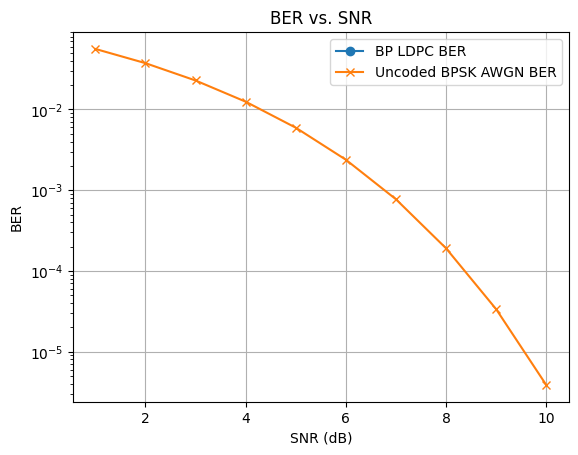

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

def theoretical_bpsk_awgn_ber(snr_db):

    # Convert SNR from dB to linear scale
    snr_linear = 10**(snr_db / 10)

    # Calculate the theoretical BER using the Q-function
    ber = 0.5 * erfc(np.sqrt(snr_linear))

    return ber

# Main simulation
if __name__ == "__main__":

    # Load parity check matrix
    H = ldpc_matrix

    # Original codeword
    original_codeword = np.zeros(48)

    # Define the zero codeword, map to bpsk
    bpsk_codeword = np.ones(48)

    # Define the range of SNRs to simulate
    snr_range = np.linspace(1, 10, 10)  # SNR from 0 dB to 10 dB

    # Simulate and calculate BER for each SNR value
    ber = simulate_ber(H, bpsk_codeword, original_codeword, snr_range)

    # Calculate the theoretical BER for BPSK in AWGN
    theoretical_ber = [theoretical_bpsk_awgn_ber(snr) for snr in snr_range]

    # Plot both BER values on the same figure
    plt.figure()
    plt.semilogy(snr_range, ber, marker='o', label='BP LDPC BER')
    plt.semilogy(snr_range, theoretical_ber, marker='x', label='Uncoded BPSK AWGN BER')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.title('BER vs. SNR')
    plt.grid(True)
    plt.legend()
    plt.show()
